In [ ]:
!pip install mat73

In [ ]:
import mat73
import scipy
import scipy.io as sio # cannot use for v7.3 mat file
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import butter, filtfilt, sosfiltfilt

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# filters

def butter_lowpass_filter(data, lowcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    b, a = butter(order, low, btype='low')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_highpass_filter(data, highcut, fs, order):
    nyq = fs/2
    high = highcut/nyq
    b, a = butter(order, high, btype='high')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    nyq = fs/2
    low = lowcut/nyq
    high = highcut/nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    # demean before filtering
    meandat = np.mean(data, axis=1)
    data = data - meandat[:, np.newaxis]
    y = sosfiltfilt(sos, data) # zero-phase filter # data: [ch x time]
    # specify pandlen to make the result the same as Matlab filtfilt()
    return y

In [ ]:
#Pre processing

def extractEpoch3D(data, event, srate, baseline, frame, opt_keep_baseline):
    # extract epoch from 2D data into 3D [ch x time x trial]
    # input: event, baseline, frame
    # extract epoch = baseline[0] to frame[2]   so the time frame is -200 to 600 ms.

    # for memory pre-allocation
    if opt_keep_baseline == True:
        begin_tmp = int(np.floor(baseline[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
    else:
        begin_tmp = int(np.floor(frame[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)

    epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
    nth_event = 0 # trial

    for i in event:
        if opt_keep_baseline == True:
            begin_id = int(i + np.floor(baseline[0]/1000 * srate))                 # int(i + begin_tmp)
            end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))   # int(i + end_tmp)
        else:
            begin_id = int(i + np.floor(frame[0]/1000 * srate))
            end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))

        tmp_data = data[:, begin_id:end_id] # extract the time period

        begin_base = int(np.floor(baseline[0]/1000 * srate))+i
        end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
        base = np.mean(data[:, begin_base:end_base], axis=1)

        rmbase_data = tmp_data - base[:, np.newaxis]
        epoch3D[:, :, nth_event] = rmbase_data
        nth_event = nth_event + 1

    return epoch3D

def decimation_by_avg(data, factor):
    """Function for replacing each sequence of previous factor samples with their average"""
    # for example, frame [0, 800]ms -> 17samples (Krusienski et al., 2006)
    # data.shape = [ch, time, trial]
    ratio_dsample = factor
    n_ch, n_frame, n_trial = data.shape

    print("n_frame" ,n_frame)
    decimated_frame = int(np.floor(n_frame/ratio_dsample))
    print("decimated_frame ",decimated_frame)

    # memory pre-allocation
    decimated_data = np.zeros((n_ch, decimated_frame, n_trial))
    print("decimated_data.shape ",decimated_data.shape)

    for i in range(n_trial):
        for j in range(decimated_frame):
            cur_data = data[:, :, i]
            decimated_data[:, j, i] = np.mean(cur_data[:, j*ratio_dsample:(j+1)*ratio_dsample], axis=1)

    return decimated_data

def detect_letter_P3speller(pred_score, word_len, label, letter_ind, markers_seq, params):
    """Function for detecing letter from the predicted results from unknown EEG"""
    user_answer = np.chararray(word_len,1)
    acc_on_repetition = np.zeros(params["full_repeat"])
    correct_on_repetition = np.zeros(params["full_repeat"])
    for n_repeat in range(params["full_repeat"]):
        for n_letter in range(word_len):
            # begin and end trial for a single letter session
            begin_trial = len(params["seq_code"]) * params["full_repeat"] * (n_letter)
            end_trial = begin_trial + (n_repeat+1) * len(params["seq_code"])

            unknown_speller_code = np.zeros(len(params["seq_code"]))
            for j in range(begin_trial, end_trial):
                # predict and add lda score
                unknown_speller_code[int(markers_seq[letter_ind[j]])-1] = unknown_speller_code[int(markers_seq[letter_ind[j]])-1] + pred_score[j]

            row = np.argmax(unknown_speller_code[0:6])
            col = np.argmax(unknown_speller_code[6:12])
            user_answer[n_letter] = params['spellermatrix'][row*6+col]
        user_answer_string = user_answer.tobytes().decode()

        correct_on_repetition[n_repeat] = len([i for i, j in zip(user_answer_string, label) if i == j])
        acc_on_repetition[n_repeat] = correct_on_repetition[n_repeat] / len(label)

    out = {"text_result": user_answer_string, "acc_on_repetition": acc_on_repetition, "correct_on_repetition": correct_on_repetition}
    return out

In [ ]:
# pre-defined parameters
baseline = [-200, 0] # in ms
frame = [0, 600] # in ms

In [ ]:
EEG = mat73.loadmat("/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/s01.mat")

# **Visualization**

Targets before ensemle

nth_event:  0  i: 5312
nth_event:  1  i: 5504
nth_event:  2  i: 6752
nth_event:  3  i: 7040
nth_event:  4  i: 7712
nth_event:  5  i: 7904
nth_event:  6  i: 9056
nth_event:  7  i: 9248
nth_event:  8  i: 10112
nth_event:  9  i: 10400


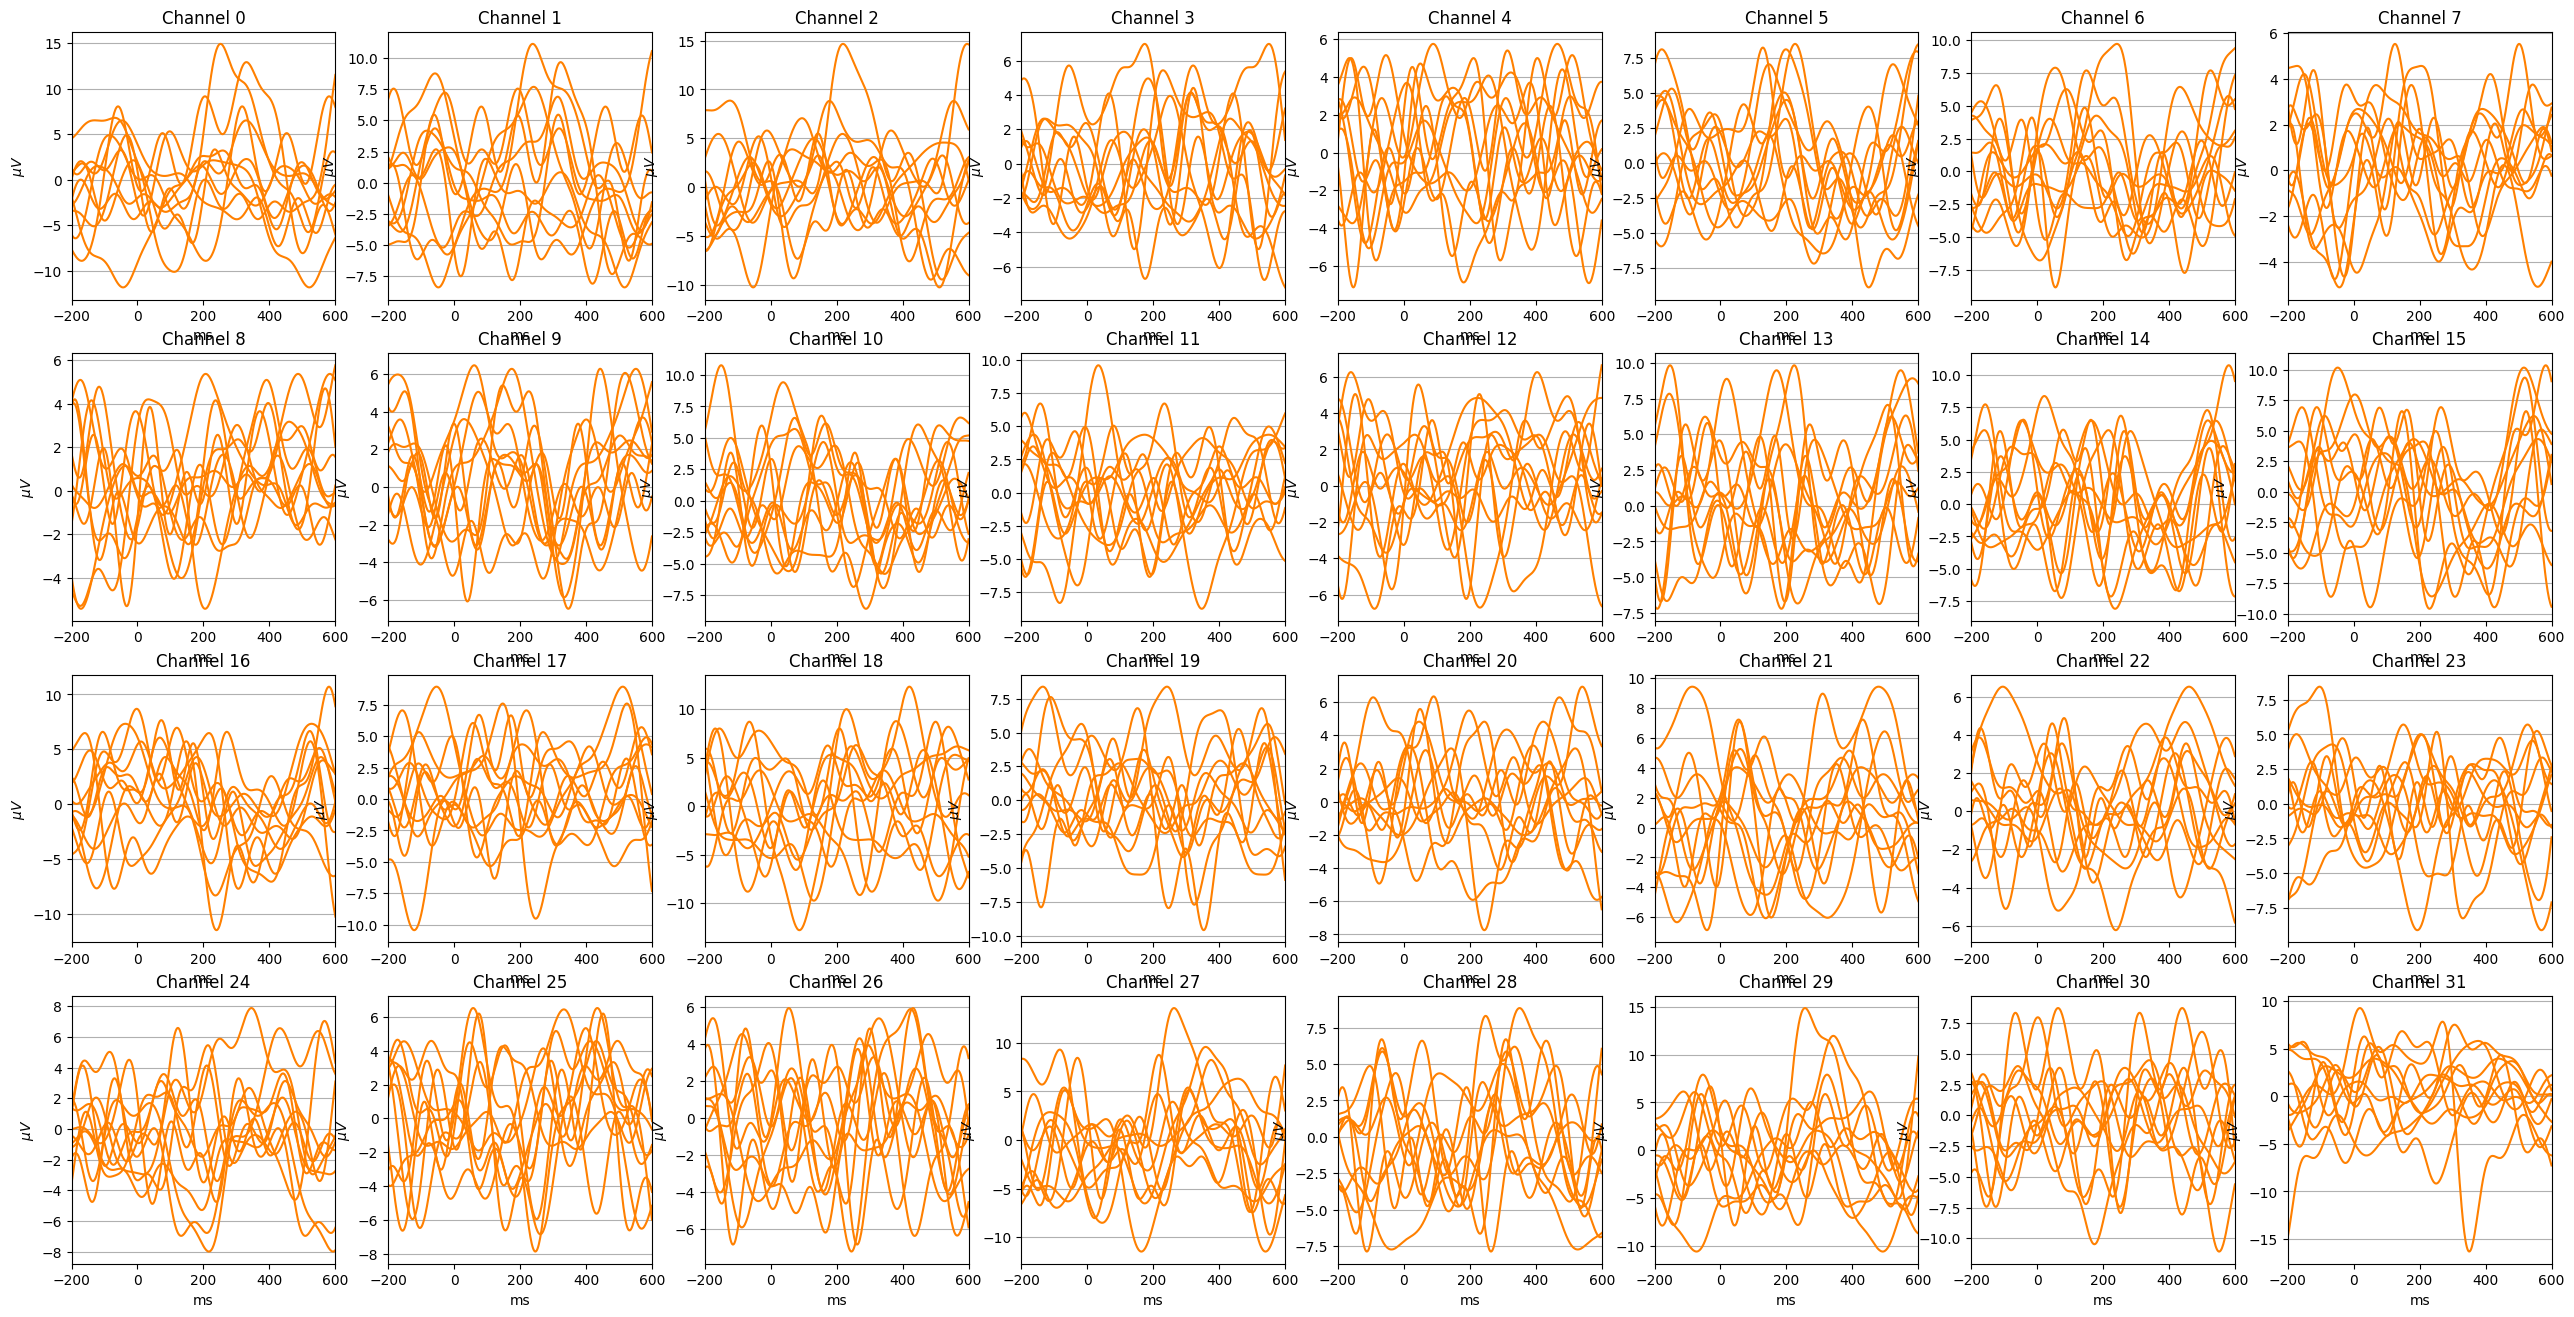

In [ ]:
eeg_data = []
eeg_data += EEG['train'] + EEG['test']

fig, axs = plt.subplots(4, 8, figsize=(32, 16))


for data_run in range(len(eeg_data)):

    # print(data_run)
    cur_eeg = eeg_data[data_run]

    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]


    event = targetID
    opt_keep_baseline = True


    if opt_keep_baseline == True:
        begin_tmp = int(np.floor(baseline[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
    else:
        begin_tmp = int(np.floor(frame[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)

    epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
    nth_event = 0 # trial

    for i in event:
        print("nth_event: ",nth_event," i:",i)
        if opt_keep_baseline == True:
            begin_id = int(i + np.floor(baseline[0]/1000 * srate))                 # int(i + begin_tmp)
            end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))   # int(i + end_tmp)
        else:
            begin_id = int(i + np.floor(frame[0]/1000 * srate))
            end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))

        tmp_data = data[:, begin_id:end_id] # extract the time period


        # Plotting
        t = np.linspace(-200, 600, tmp_data.shape[1])
        target_before_ensemble = tmp_data
        # avg_nontarget =
        for channel_num in range(tmp_data.shape[0]):

          row, col = divmod(channel_num, 8)

          axs[row, col].plot(t, target_before_ensemble[channel_num, :].transpose(), color=[1, 0.5, 0], label='Target')
          # axs[row, col].plot(t, avg_nontarget[channel_num, :].transpose(), color=[0, 0, 0], label='Average Non-Target')

          axs[row, col].set_title("Channel %s" % (channel_num))
          axs[row, col].set_xlabel('ms')
          axs[row, col].set_ylabel(r'$\mu V$')
          axs[row, col].yaxis.grid(True)
          axs[row, col].set_xlim([-200, 600])

        # begin_base = int(np.floor(baseline[0]/1000 * srate))+i
        # end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
        # base = np.mean(data[:, begin_base:end_base], axis=1)

        # rmbase_data = tmp_data - base[:, np.newaxis]
        # epoch3D[:, :, nth_event] = rmbase_data
        nth_event = nth_event + 1
        if nth_event == 10:
          break
    break


nth_event:  0  i: 5120
nth_event:  1  i: 5216
nth_event:  2  i: 5408
nth_event:  3  i: 5600


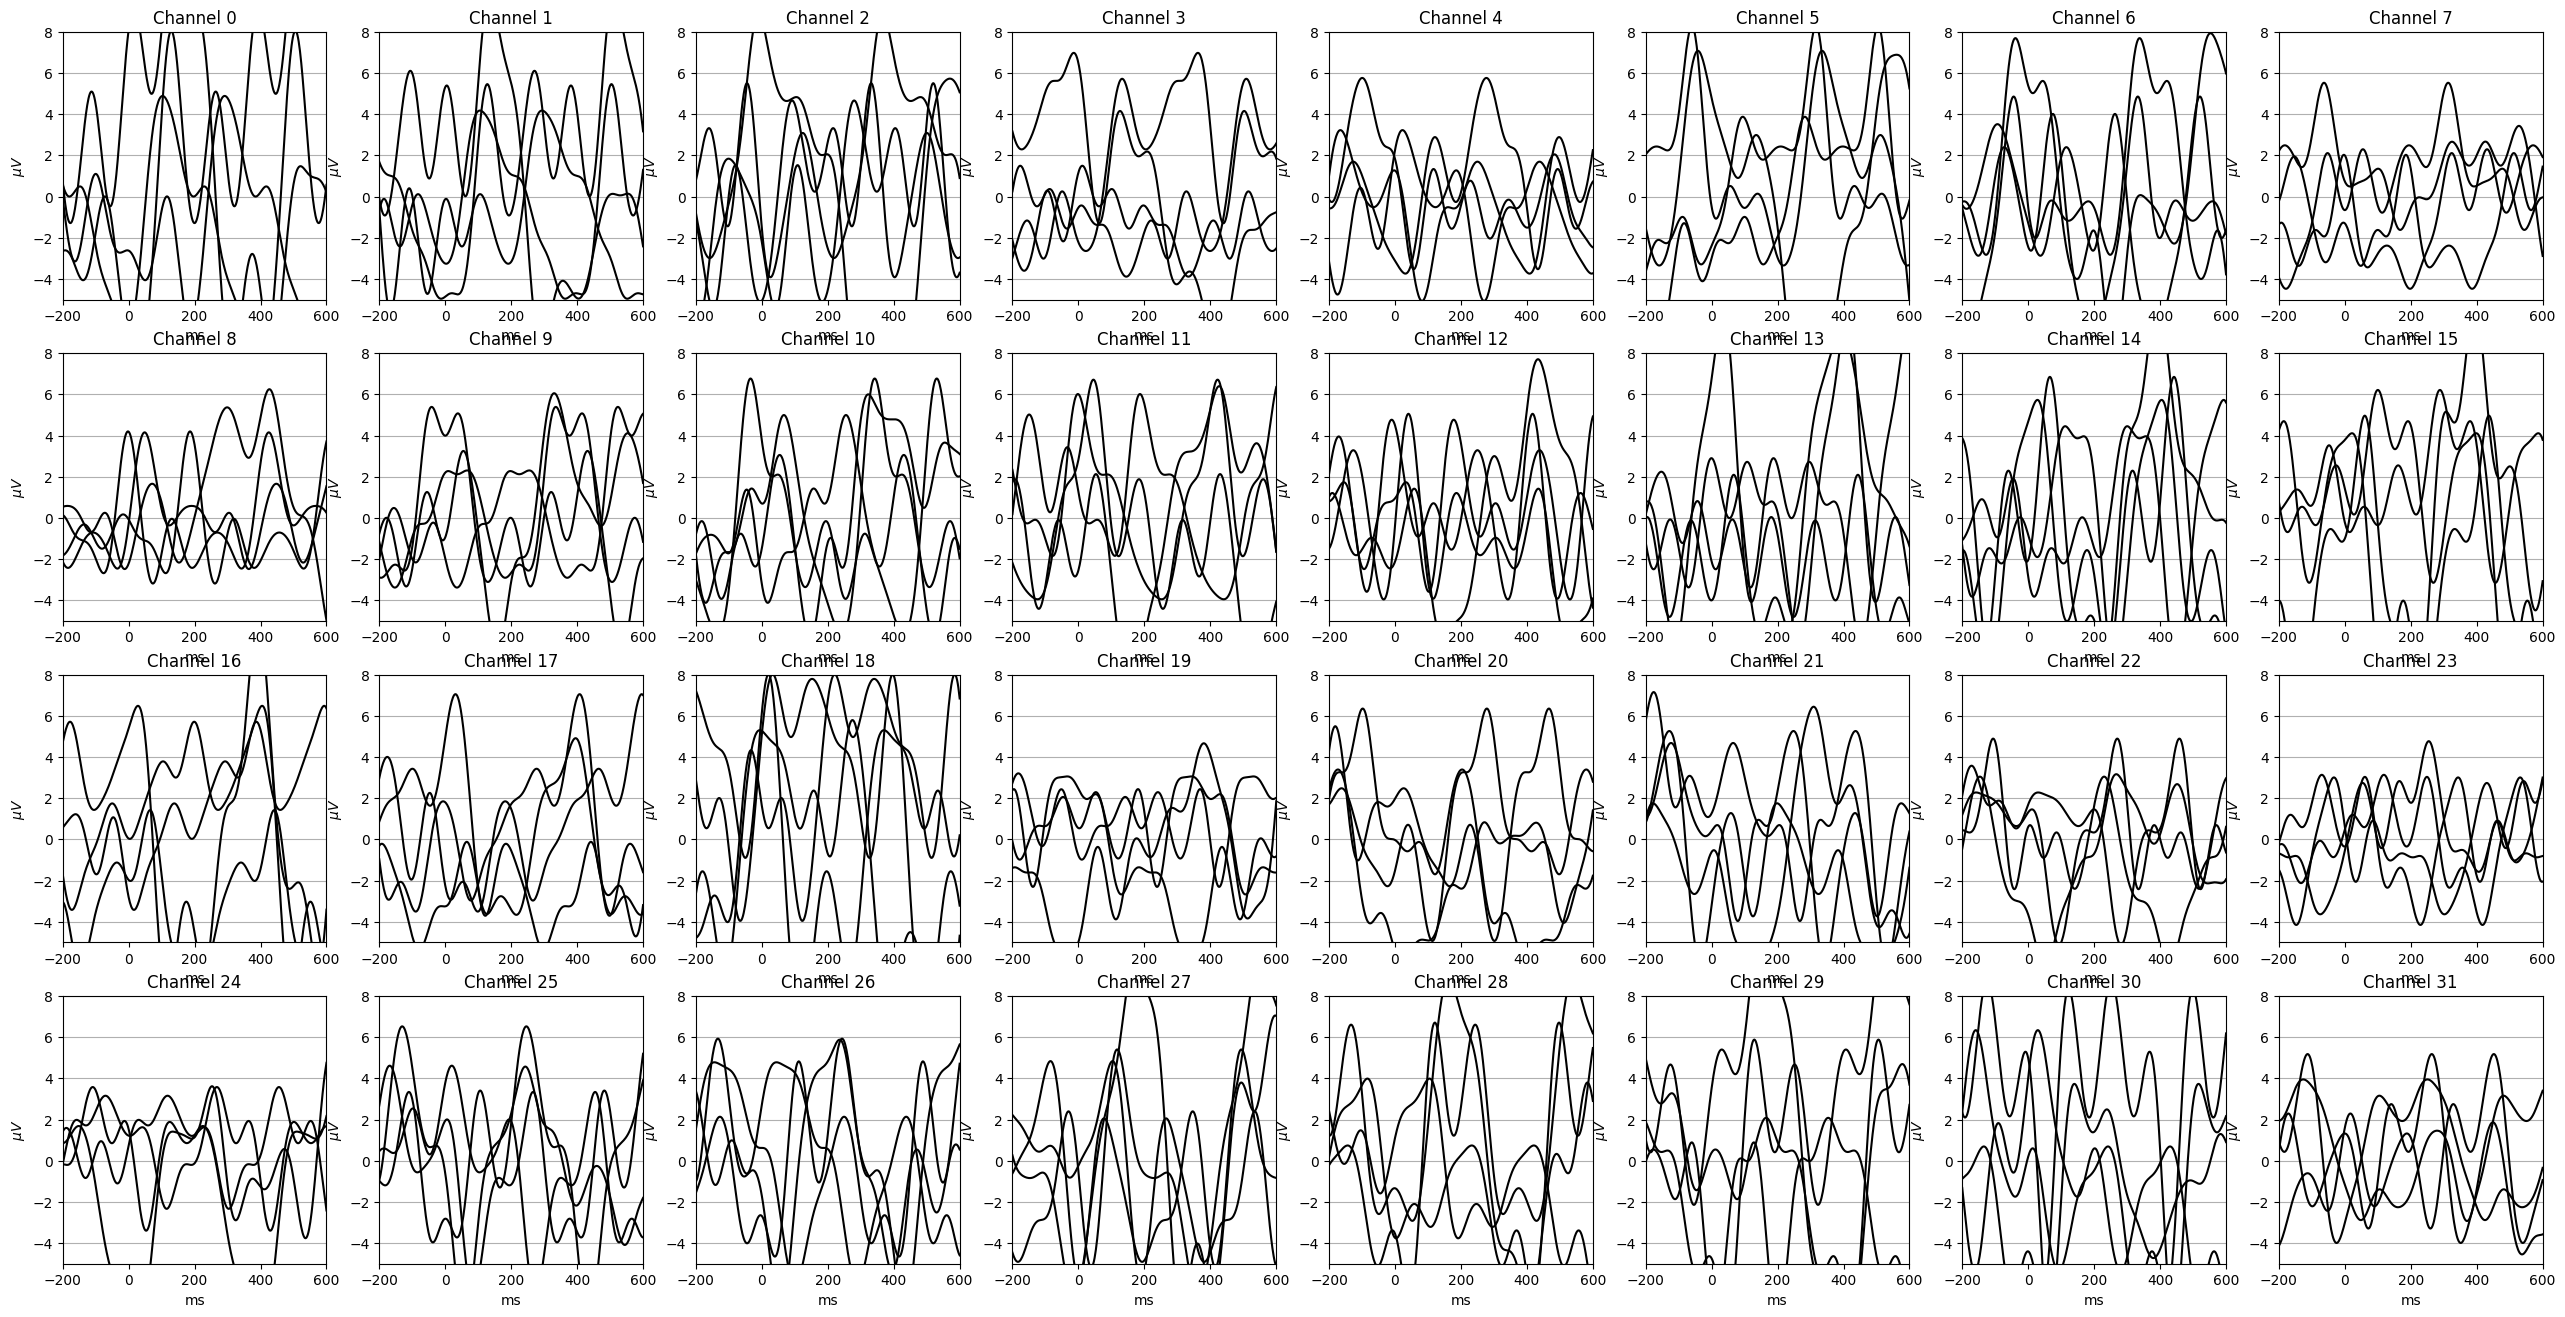

In [ ]:

fig, axs = plt.subplots(4, 8, figsize=(32, 16))


for data_run in range(len(eeg_data)):

    # print(data_run)
    cur_eeg = eeg_data[data_run]

    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]


    event = nontargetID
    opt_keep_baseline = True


    if opt_keep_baseline == True:
        begin_tmp = int(np.floor(baseline[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-baseline[0])/1000*srate)
    else:
        begin_tmp = int(np.floor(frame[0]/1000*srate))
        end_tmp = int(begin_tmp+np.floor(frame[1]-frame[0])/1000*srate)

    epoch3D = np.zeros((data.shape[0], end_tmp-begin_tmp, len(event)))
    nth_event = 0 # trial

    for i in event:
        print("nth_event: ",nth_event," i:",i)
        if opt_keep_baseline == True:
            begin_id = int(i + np.floor(baseline[0]/1000 * srate))                 # int(i + begin_tmp)
            end_id = int(begin_id + np.floor((frame[1]-baseline[0])/1000*srate))   # int(i + end_tmp)
        else:
            begin_id = int(i + np.floor(frame[0]/1000 * srate))
            end_id = int(begin_id + np.floor((frame[1]-frame[0])/1000*srate))

        tmp_data = data[:, begin_id:end_id] # extract the time period


        # Plotting
        t = np.linspace(-200, 600, tmp_data.shape[1])
        # target_before_ensemble = tmp_data
        nontarget_before_ensemble = tmp_data
        # avg_nontarget =
        for channel_num in range(tmp_data.shape[0]):

          row, col = divmod(channel_num, 8)

          # axs[row, col].plot(t, target_before_ensemble[channel_num, :].transpose(), color=[1, 0.5, 0], label='Target')
          axs[row, col].plot(t, nontarget_before_ensemble[channel_num, :].transpose(), color=[0, 0, 0], label='Average Non-Target')

          axs[row, col].set_title("Channel %s" % (channel_num))
          axs[row, col].set_xlabel('ms')
          axs[row, col].set_ylabel(r'$\mu V$')
          axs[row, col].yaxis.grid(True)
          axs[row, col].set_xlim([-200, 600])
          axs[row, col].set_ylim([-5, 8])


        # begin_base = int(np.floor(baseline[0]/1000 * srate))+i
        # end_base = int(begin_base + np.floor(np.diff(baseline)/1000 * srate)-1)
        # base = np.mean(data[:, begin_base:end_base], axis=1)

        # rmbase_data = tmp_data - base[:, np.newaxis]
        # epoch3D[:, :, nth_event] = rmbase_data
        nth_event = nth_event + 1
        if nth_event == 4:
          break
    break


# **Ensemble**

In [ ]:
targetEEG.shape

(32, 409, 1140)

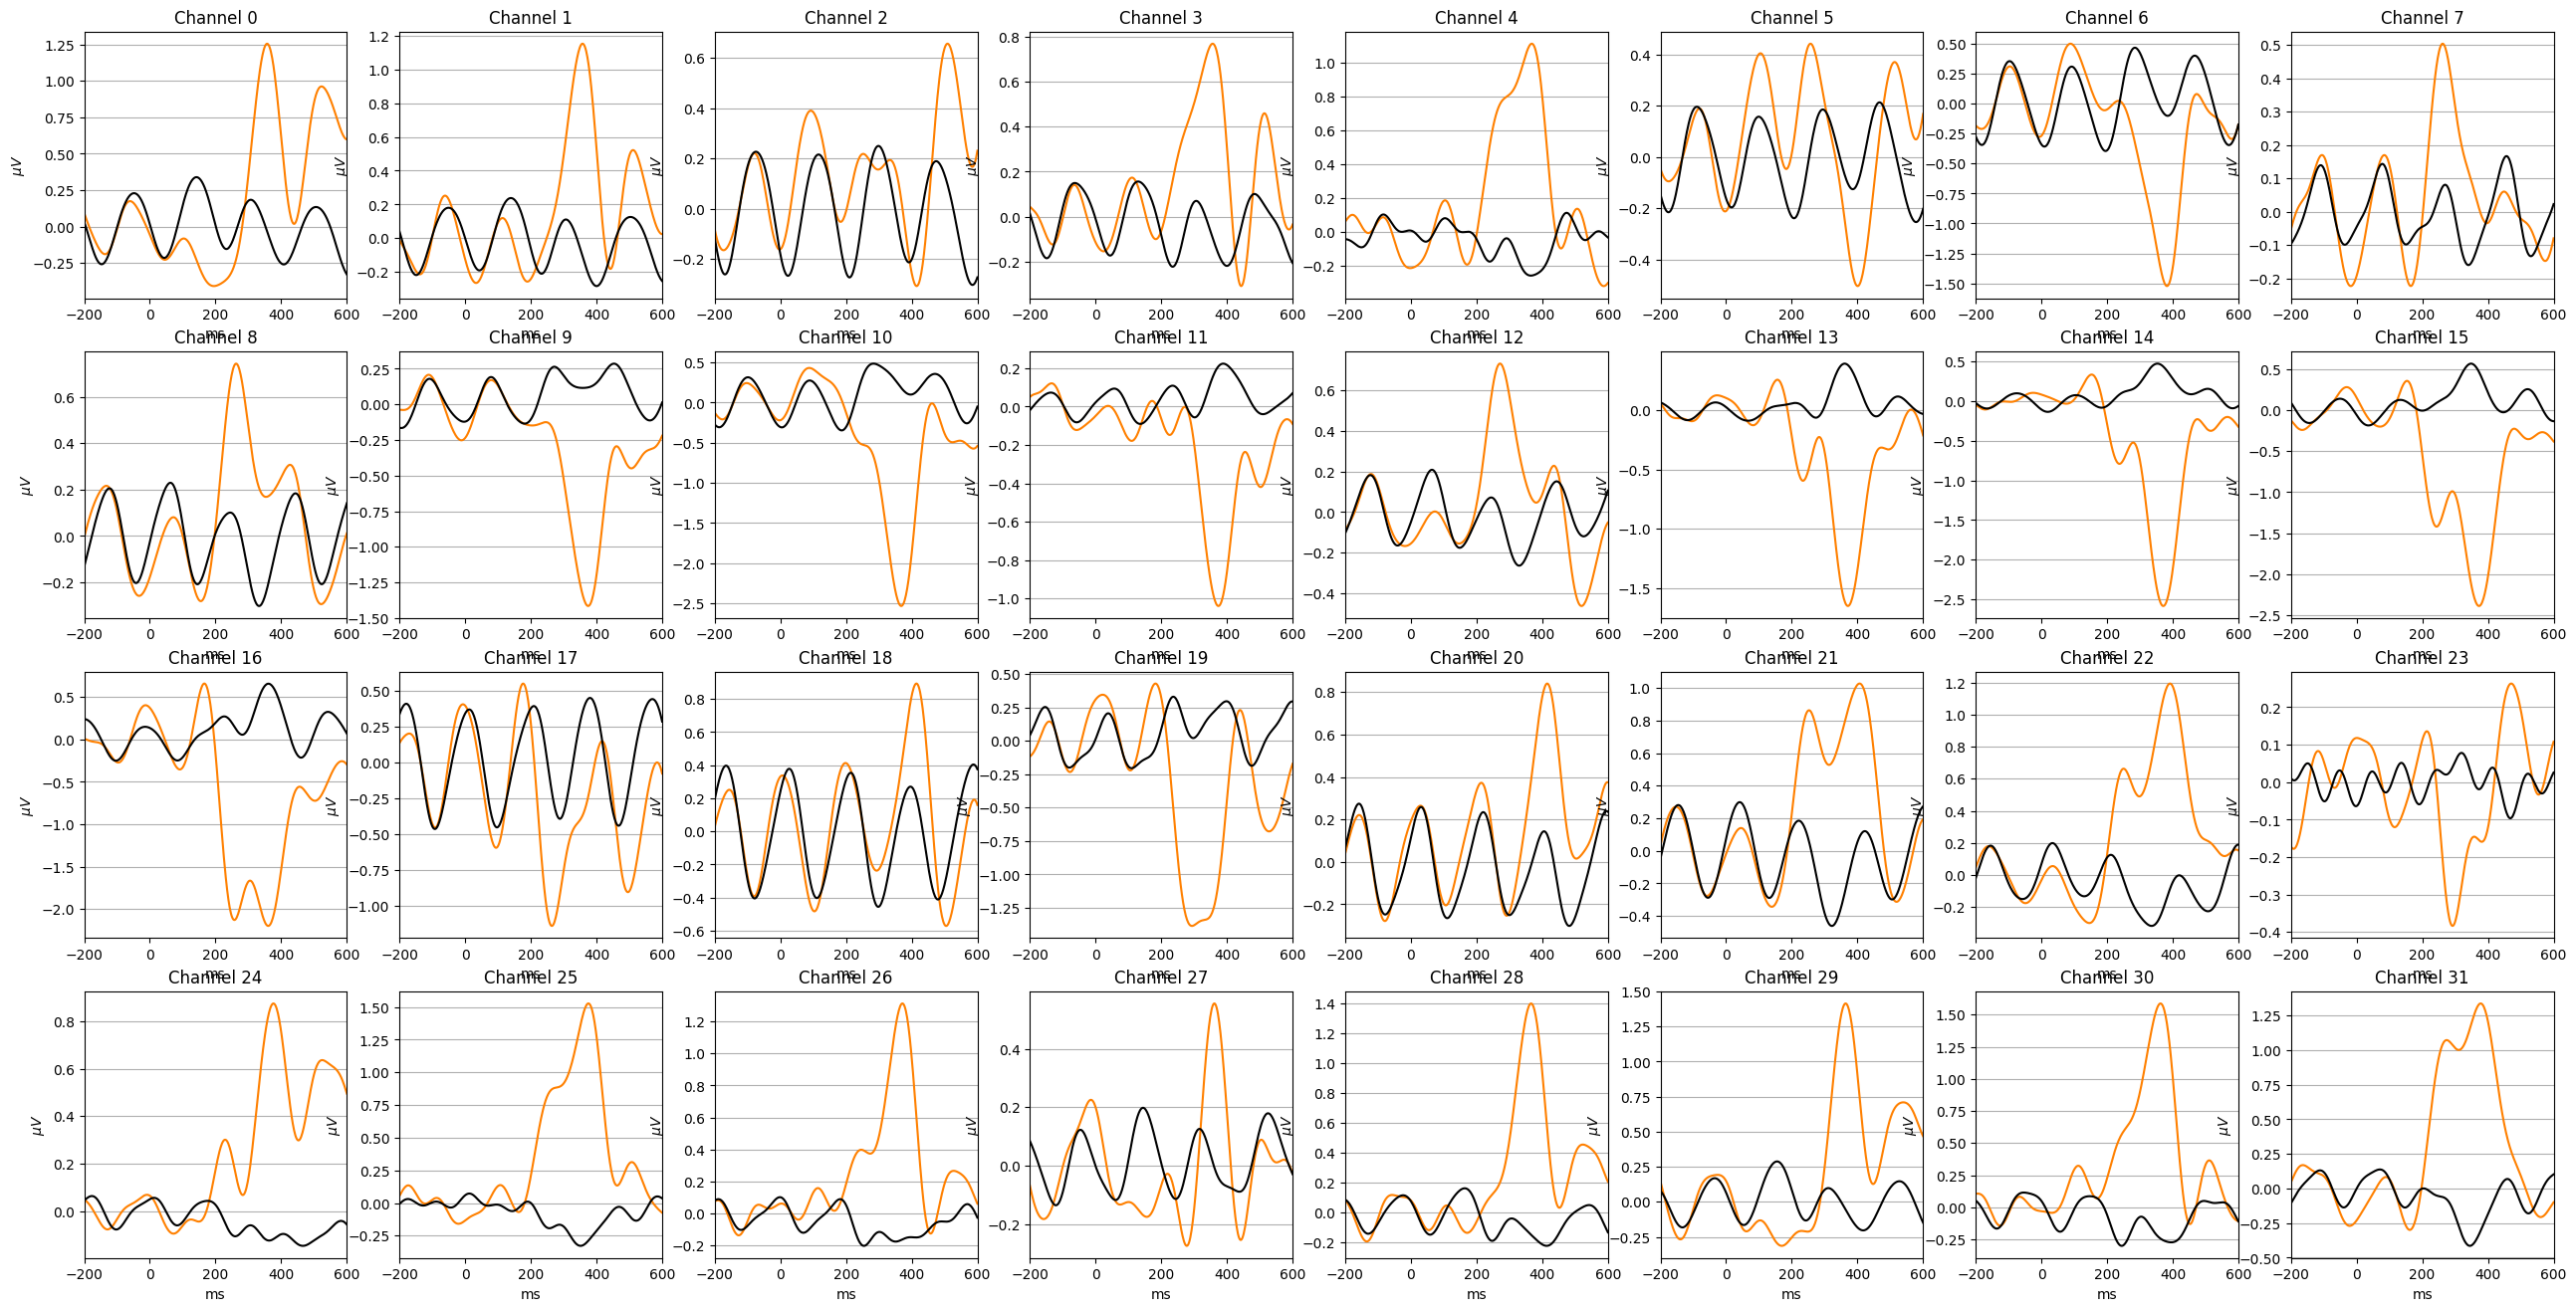

In [ ]:
#Load Dataset

# EEG_data = []
# path = "/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/"
# for subject in range(1,5):
#     eeg = mat73.loadmat(path+'s{:02d}.mat'.format(int(subject)))
#     EEG_data += eeg['train'] + eeg['test']

# Pre-processing for training EEG
eeg_data = []
eeg_data += EEG['train'] + EEG['test']


fig, axs = plt.subplots(4, 8, figsize=(32, 16))

for n_calib in range(len(eeg_data)):
    # print(n_calib)
    cur_eeg = eeg_data[n_calib]

    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]

    tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
    tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
    if n_calib == 0:
        targetEEG = tmp_targetEEG
        nontargetEEG = tmp_nontargetEEG
    else:
        targetEEG = np.dstack((targetEEG, tmp_targetEEG))
        nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))

# Ensemble accross 1140(target) trials
avg_target = np.mean(targetEEG, axis=2)
avg_nontarget = np.mean(nontargetEEG, axis=2)

# Plotting
t = np.linspace(-200, 600, avg_target.shape[1])

# avg_nontarget =
for channel_num in range(tmp_data.shape[0]):

  row, col = divmod(channel_num, 8)

  axs[row, col].plot(t, avg_target[channel_num, :].transpose(), color=[1, 0.5, 0], label='Target')
  axs[row, col].plot(t, avg_nontarget[channel_num, :].transpose(), color=[0, 0, 0], label='Average Non-Target')

  axs[row, col].set_title("Channel %s" % (channel_num))
  axs[row, col].set_xlabel('ms')
  axs[row, col].set_ylabel(r'$\mu V$')
  axs[row, col].yaxis.grid(True)
  axs[row, col].set_xlim([-200, 600])




# # Averaging in time axis
# down_target = decimation_by_avg(targetEEG, 24)
# down_nontarget = decimation_by_avg(nontargetEEG, 24)

# ch_target, frame_target, trial_target = down_target.shape
# ch_nontarget, frame_nontarget, trial_nontarget = down_nontarget.shape

# # ch x time x trial -> (ch* time) x trial -> trial x (ch*time)
# feat_target = np.reshape(down_target, (ch_target*frame_target, trial_target)).transpose()
# feat_nontarget = np.reshape(down_nontarget, (ch_nontarget*frame_nontarget, trial_nontarget)).transpose()

# # labels - (+1) for target and (-1) for nontarget
# y_target = np.ones((feat_target.shape[0],1))
# y_nontarget = -np.ones((feat_nontarget.shape[0],1))

# X_ = np.vstack((feat_target, feat_nontarget))
# y_ = np.vstack((y_target, y_nontarget))

# print(X_.shape, y_.shape)

# # shuffle target and nontarget indices
# np.random.seed(101)
# idx_train = np.arange(X_.shape[0])
# np.random.shuffle(idx_train)
# X_ = X_[idx_train, :]
# y_ = y_[idx_train, :]

# X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)



In [ ]:
n = [1,23,2]
n[0:-1]

[1, 23]

# **Ensemble and time Down Sampling**

n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 8)
n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 44)


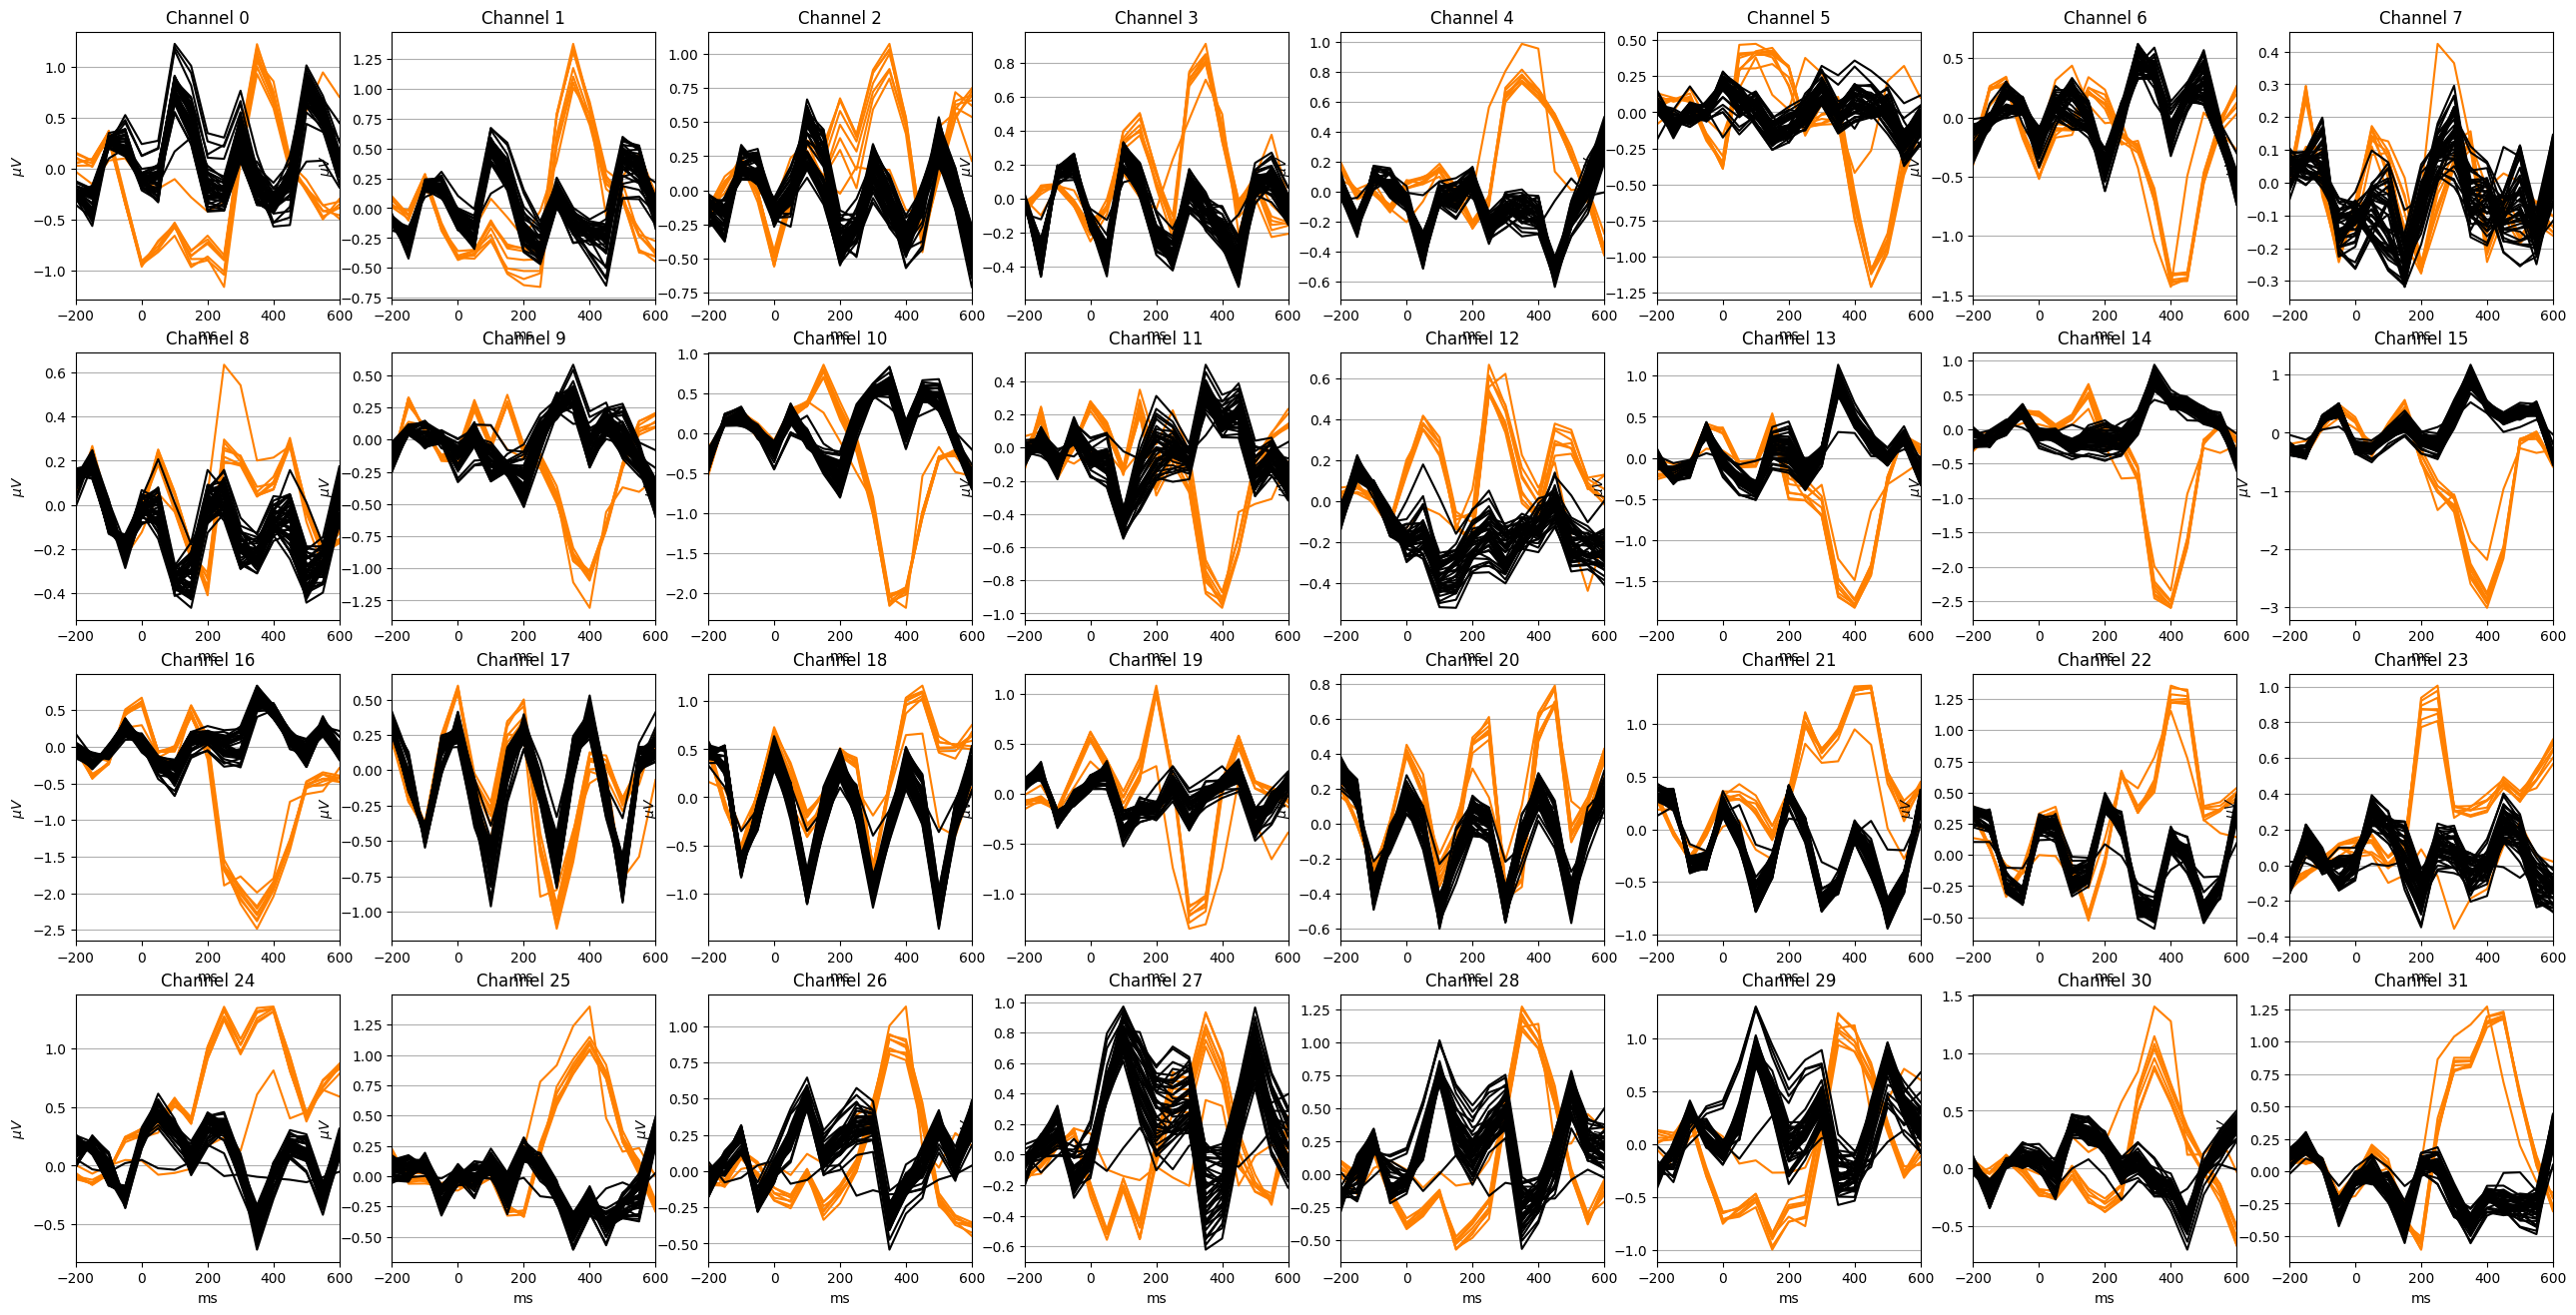

In [ ]:
#Load Dataset

# EEG_data = []
# path = "/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/"
# for subject in range(1,5):
#     eeg = mat73.loadmat(path+'s{:02d}.mat'.format(int(subject)))
#     EEG_data += eeg['train'] + eeg['test']

# Pre-processing for training EEG
eeg_data = []
eeg_data += EEG['train'] + EEG['test']


fig, axs = plt.subplots(4, 8, figsize=(32, 16))

for n_calib in range(len(eeg_data)):
    # print(n_calib)
    cur_eeg = eeg_data[n_calib]

    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]

    tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
    tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
    if n_calib == 0:
        targetEEG = tmp_targetEEG
        nontargetEEG = tmp_nontargetEEG
    else:
        targetEEG = np.dstack((targetEEG, tmp_targetEEG))
        nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))


# Ensemble accross trials
num_of_target_signals = targetEEG.shape[2] // 128
num_of_nontarget_signals = nontargetEEG.shape[2] // 128
avg_target = np.zeros((targetEEG.shape[0], targetEEG.shape[1], num_of_target_signals))
avg_nontarget = np.zeros((nontargetEEG.shape[0], nontargetEEG.shape[1], num_of_nontarget_signals))

for i in range(num_of_target_signals):
  if i != num_of_target_signals-1:
    avg_target[:,:,i] = np.mean(targetEEG[:, :, i:i+128 ], axis=2)
  else:
    avg_target[:,:,i] = np.mean(targetEEG[:, :, i: ], axis=2)

for i in range(num_of_nontarget_signals):
  if i != num_of_nontarget_signals-1:
    avg_nontarget[:,:,i] = np.mean(nontargetEEG[:, :, i:i+128 ], axis=2)
  else:
    avg_nontarget[:,:,i] = np.mean(nontargetEEG[:, :, i: ], axis=2)



# Averaging in time axis
down_target = decimation_by_avg(avg_target, 24)
down_nontarget = decimation_by_avg(avg_nontarget, 24)

# Plotting
t = np.linspace(-200, 600, down_target.shape[1])

for channel_num in range(down_target.shape[0]):

  row, col = divmod(channel_num, 8)

  axs[row, col].plot(t, down_target[channel_num, :], color=[1, 0.5, 0], label='Target')
  axs[row, col].plot(t, down_nontarget[channel_num, :], color=[0, 0, 0], label='Average Non-Target')

  axs[row, col].set_title("Channel %s" % (channel_num))
  axs[row, col].set_xlabel('ms')
  axs[row, col].set_ylabel(r'$\mu V$')
  axs[row, col].yaxis.grid(True)
  axs[row, col].set_xlim([-200, 600])





# ch_target, frame_target, trial_target = down_target.shape
# ch_nontarget, frame_nontarget, trial_nontarget = down_nontarget.shape

# # ch x time x trial -> (ch* time) x trial -> trial x (ch*time)
# feat_target = np.reshape(down_target, (ch_target*frame_target, trial_target)).transpose()
# feat_nontarget = np.reshape(down_nontarget, (ch_nontarget*frame_nontarget, trial_nontarget)).transpose()

# # labels - (+1) for target and (-1) for nontarget
# y_target = np.ones((feat_target.shape[0],1))
# y_nontarget = -np.ones((feat_nontarget.shape[0],1))

# X_ = np.vstack((feat_target, feat_nontarget))
# y_ = np.vstack((y_target, y_nontarget))

# print(X_.shape, y_.shape)

# # shuffle target and nontarget indices
# np.random.seed(101)
# idx_train = np.arange(X_.shape[0])
# np.random.shuffle(idx_train)
# X_ = X_[idx_train, :]
# y_ = y_[idx_train, :]

# X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)



# **Visualization of the final data series**

n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 8)
n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 44)


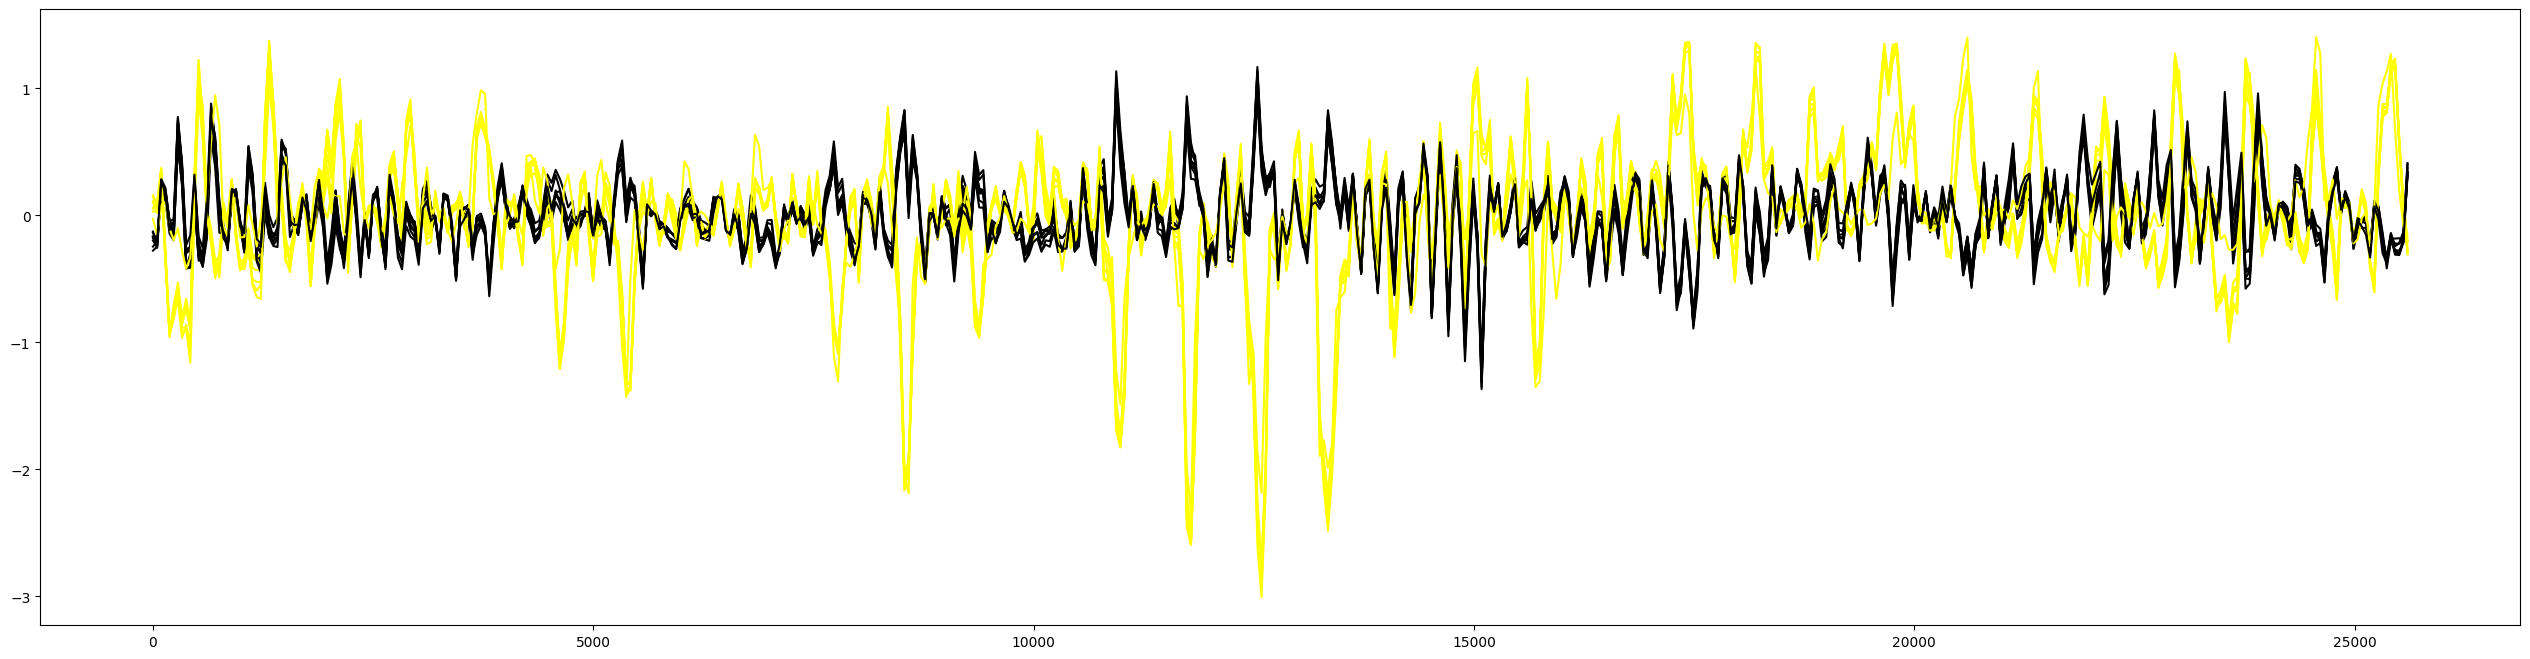

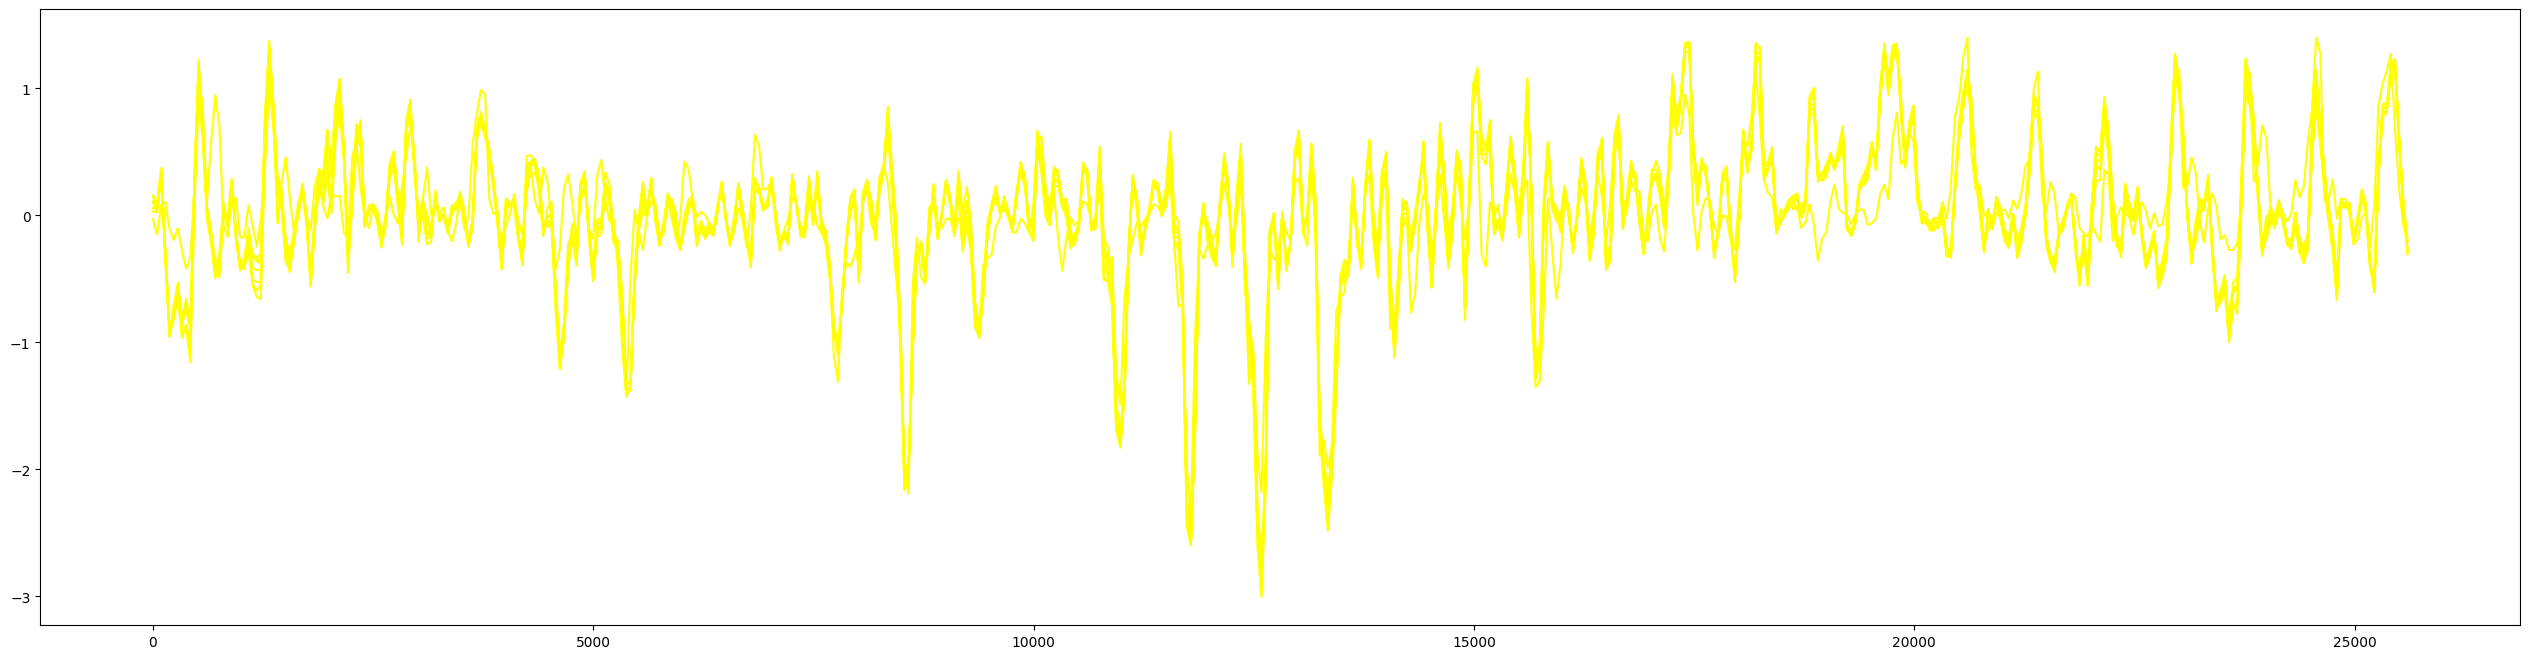

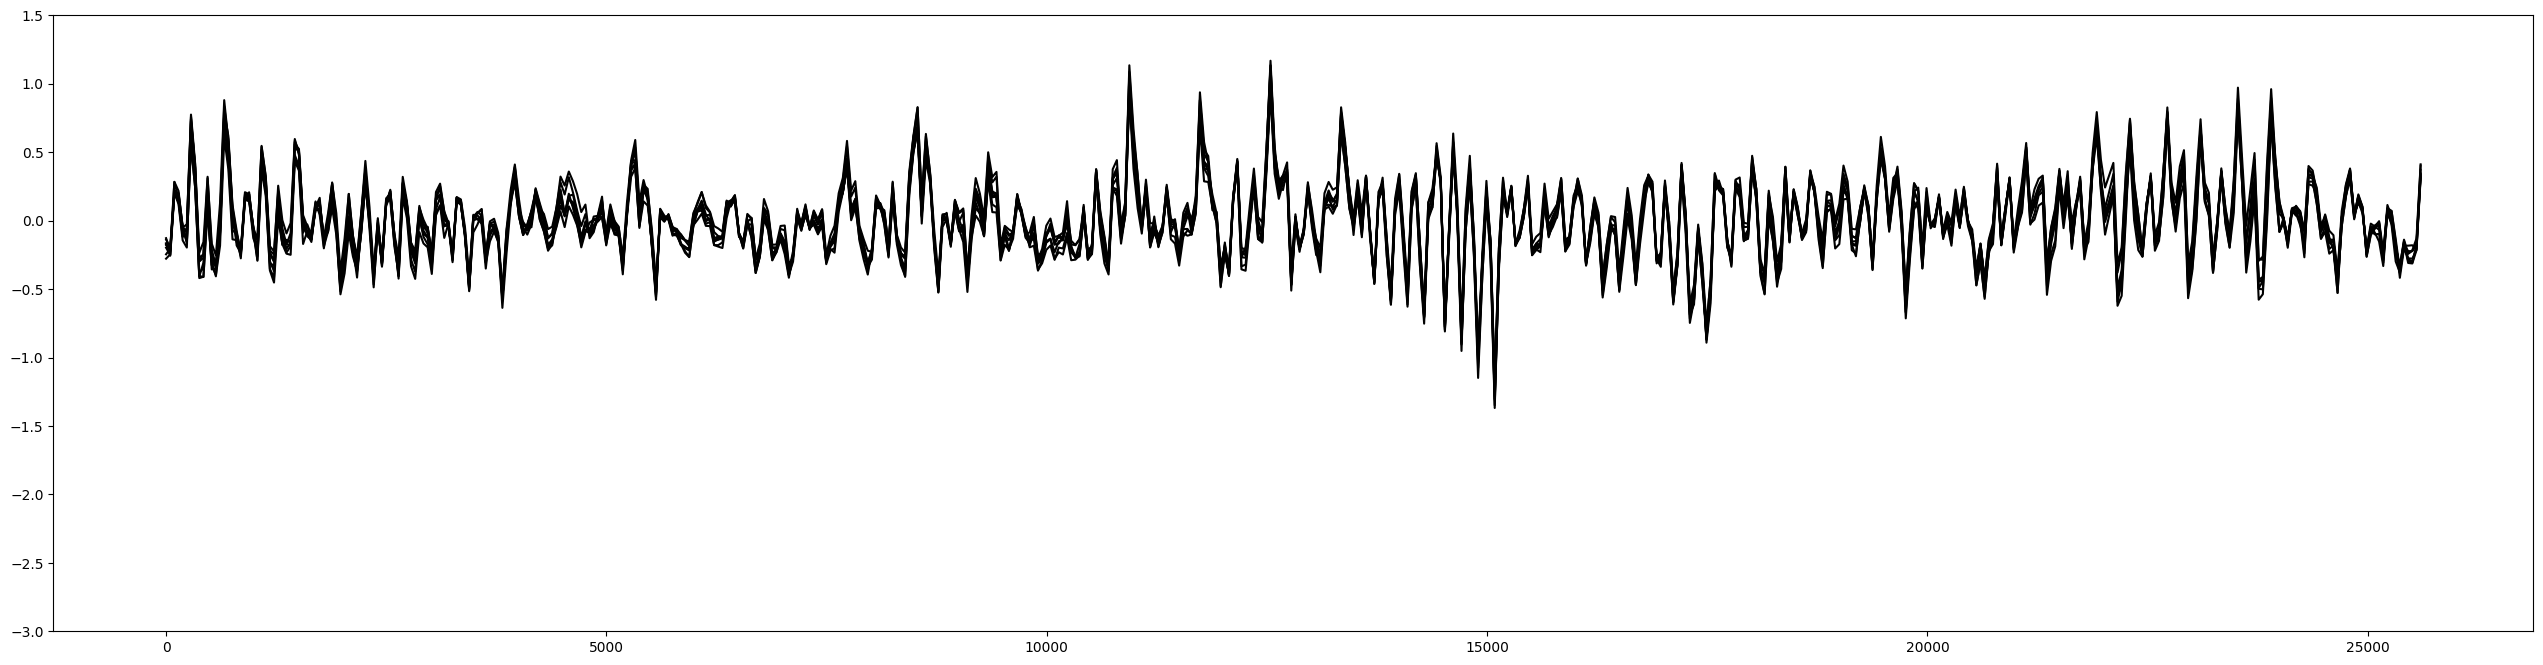

In [ ]:
#Load Dataset

# EEG_data = []
# path = "/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/"
# for subject in range(1,5):
#     eeg = mat73.loadmat(path+'s{:02d}.mat'.format(int(subject)))
#     EEG_data += eeg['train'] + eeg['test']

# Pre-processing for training EEG
eeg_data = []
eeg_data += EEG['train'] + EEG['test']


for n_calib in range(len(eeg_data)):
    # print(n_calib)
    cur_eeg = eeg_data[n_calib]

    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]

    tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
    tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
    if n_calib == 0:
        targetEEG = tmp_targetEEG
        nontargetEEG = tmp_nontargetEEG
    else:
        targetEEG = np.dstack((targetEEG, tmp_targetEEG))
        nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))


# Ensemble accross trials
num_of_target_signals = targetEEG.shape[2] // 128
num_of_nontarget_signals = nontargetEEG.shape[2] // 128
avg_target = np.zeros((targetEEG.shape[0], targetEEG.shape[1], num_of_target_signals))
avg_nontarget = np.zeros((nontargetEEG.shape[0], nontargetEEG.shape[1], num_of_nontarget_signals))

for i in range(num_of_target_signals):
  if i != num_of_target_signals-1:
    avg_target[:,:,i] = np.mean(targetEEG[:, :, i:i+128 ], axis=2)
  else:
    avg_target[:,:,i] = np.mean(targetEEG[:, :, i: ], axis=2)

for i in range(num_of_nontarget_signals):
  if i != num_of_nontarget_signals-1:
    avg_nontarget[:,:,i] = np.mean(nontargetEEG[:, :, i:i+128 ], axis=2)
  else:
    avg_nontarget[:,:,i] = np.mean(nontargetEEG[:, :, i: ], axis=2)



# Averaging in time axis
down_target = decimation_by_avg(avg_target, 24)
down_nontarget = decimation_by_avg(avg_nontarget, 24)



ch_target, frame_target, trial_target = down_target.shape
ch_nontarget, frame_nontarget, trial_nontarget = down_nontarget.shape

# ch x time x trial -> (ch* time) x trial -> trial x (ch*time)
feat_target = np.reshape(down_target, (ch_target*frame_target, trial_target)).transpose()
feat_nontarget = np.reshape(down_nontarget, (ch_nontarget*frame_nontarget, trial_nontarget)).transpose()

# # labels - (+1) for target and (-1) for nontarget
# y_target = np.ones((feat_target.shape[0],1))
# y_nontarget = -np.ones((feat_nontarget.shape[0],1))

# X_ = np.vstack((feat_target, feat_nontarget))
# y_ = np.vstack((y_target, y_nontarget))

# print(X_.shape, y_.shape)

# # shuffle target and nontarget indices
# np.random.seed(101)
# idx_train = np.arange(X_.shape[0])
# np.random.shuffle(idx_train)
# X_ = X_[idx_train, :]
# y_ = y_[idx_train, :]

# X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)






# Plotting
t = np.linspace(0, 32*800 , feat_target.shape[1])
plt.figure(figsize=(32,8))

for trial in range(feat_target.shape[0]):
  plt.plot(t,feat_target[trial], color='yellow')
  plt.plot(t,feat_nontarget[trial], color='black')
plt.show()

plt.figure(figsize=(32,8))
for trial in range(feat_target.shape[0]):
  plt.plot(t,feat_target[trial], color='yellow')
plt.show()

plt.figure(figsize=(32,8))
for trial in range(feat_target.shape[0]):
  plt.plot(t,feat_nontarget[trial], color='black')
plt.ylim(-3, 1.5)
plt.show()




# **After standerize**

n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 8)
n_frame 409
decimated_frame  17
decimated_data.shape  (32, 17, 44)


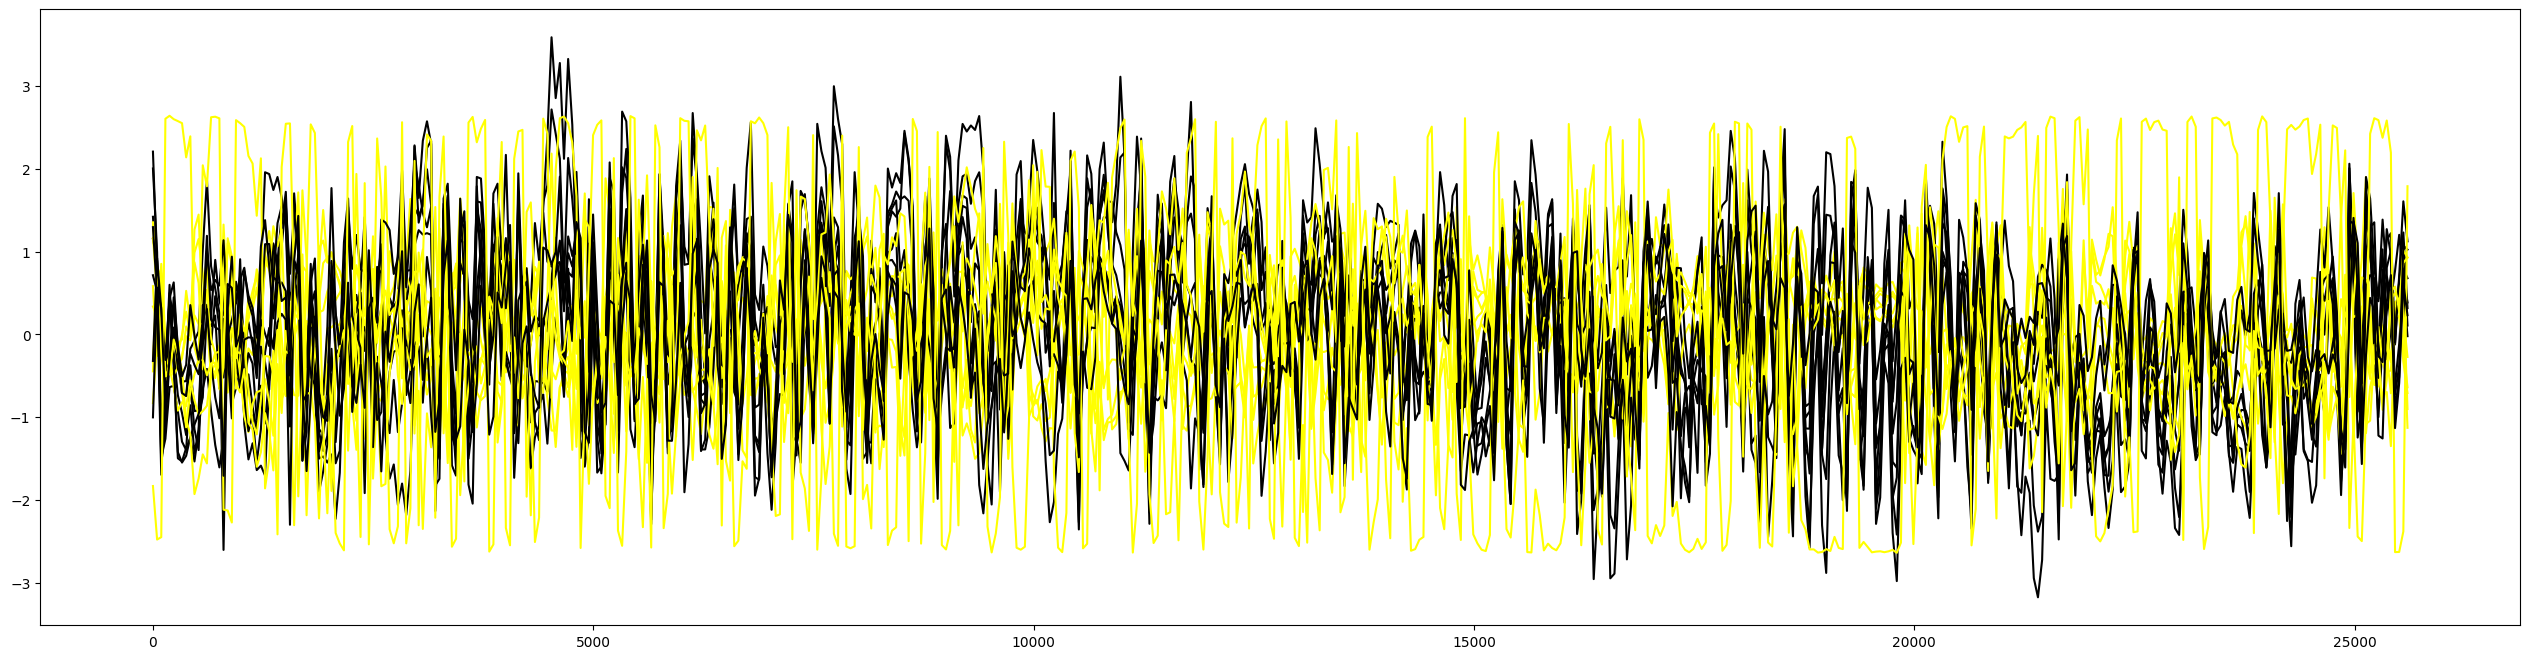

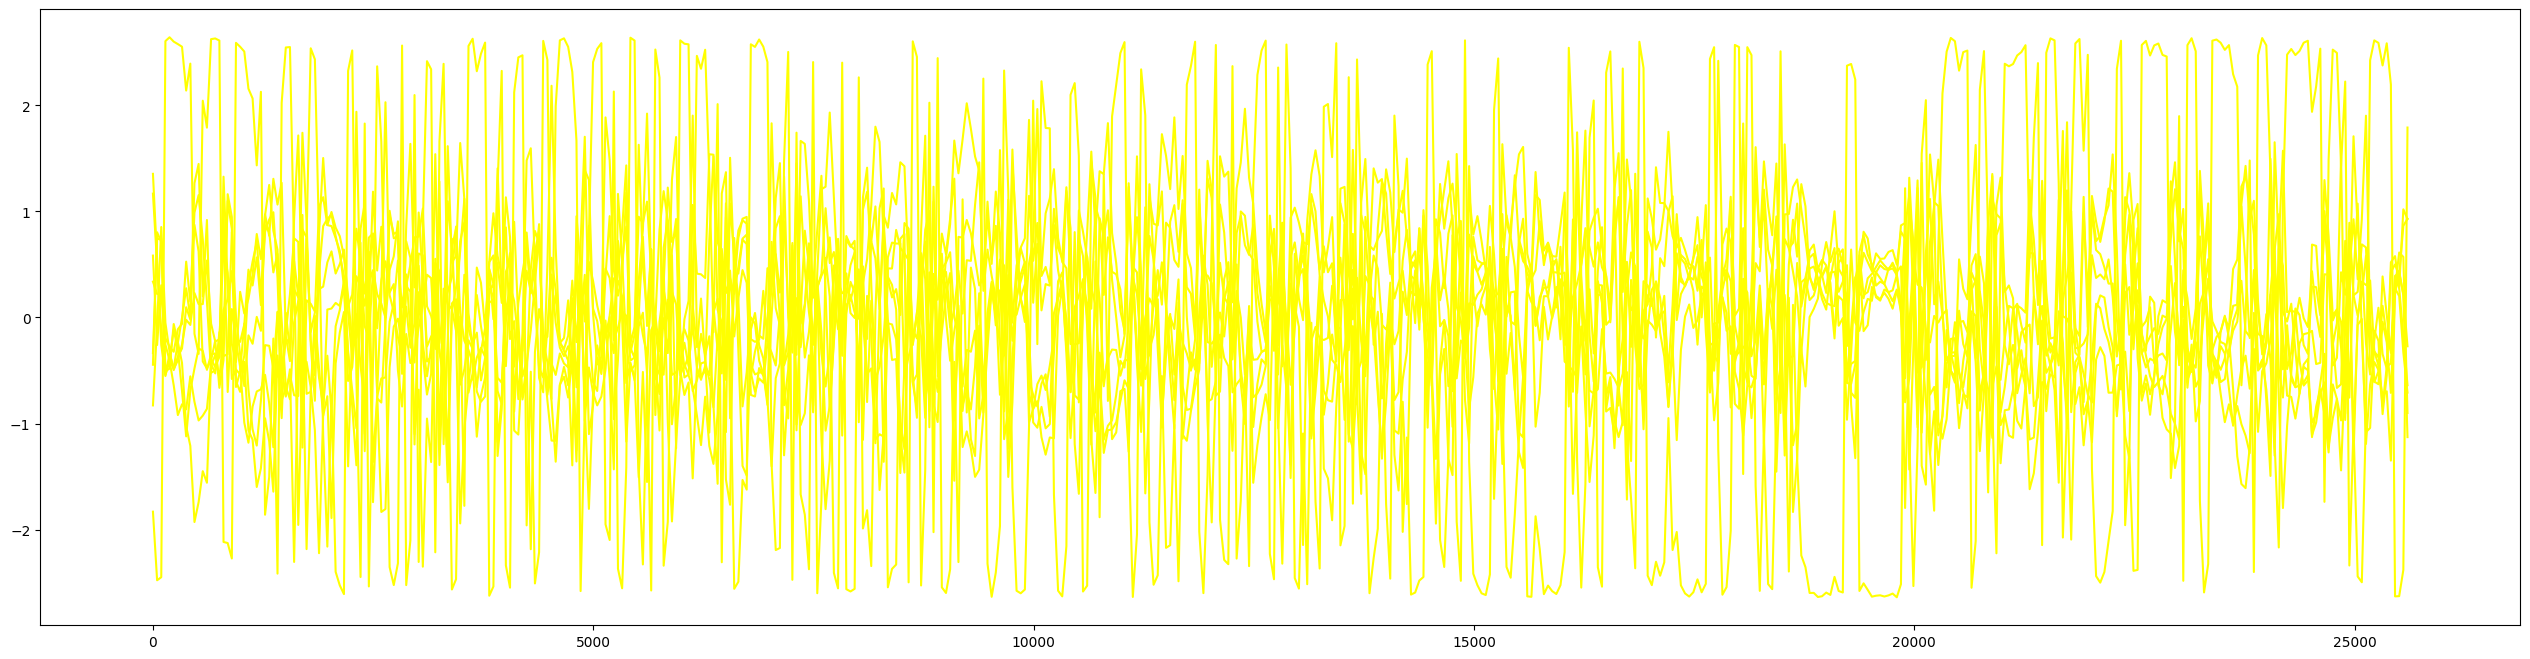

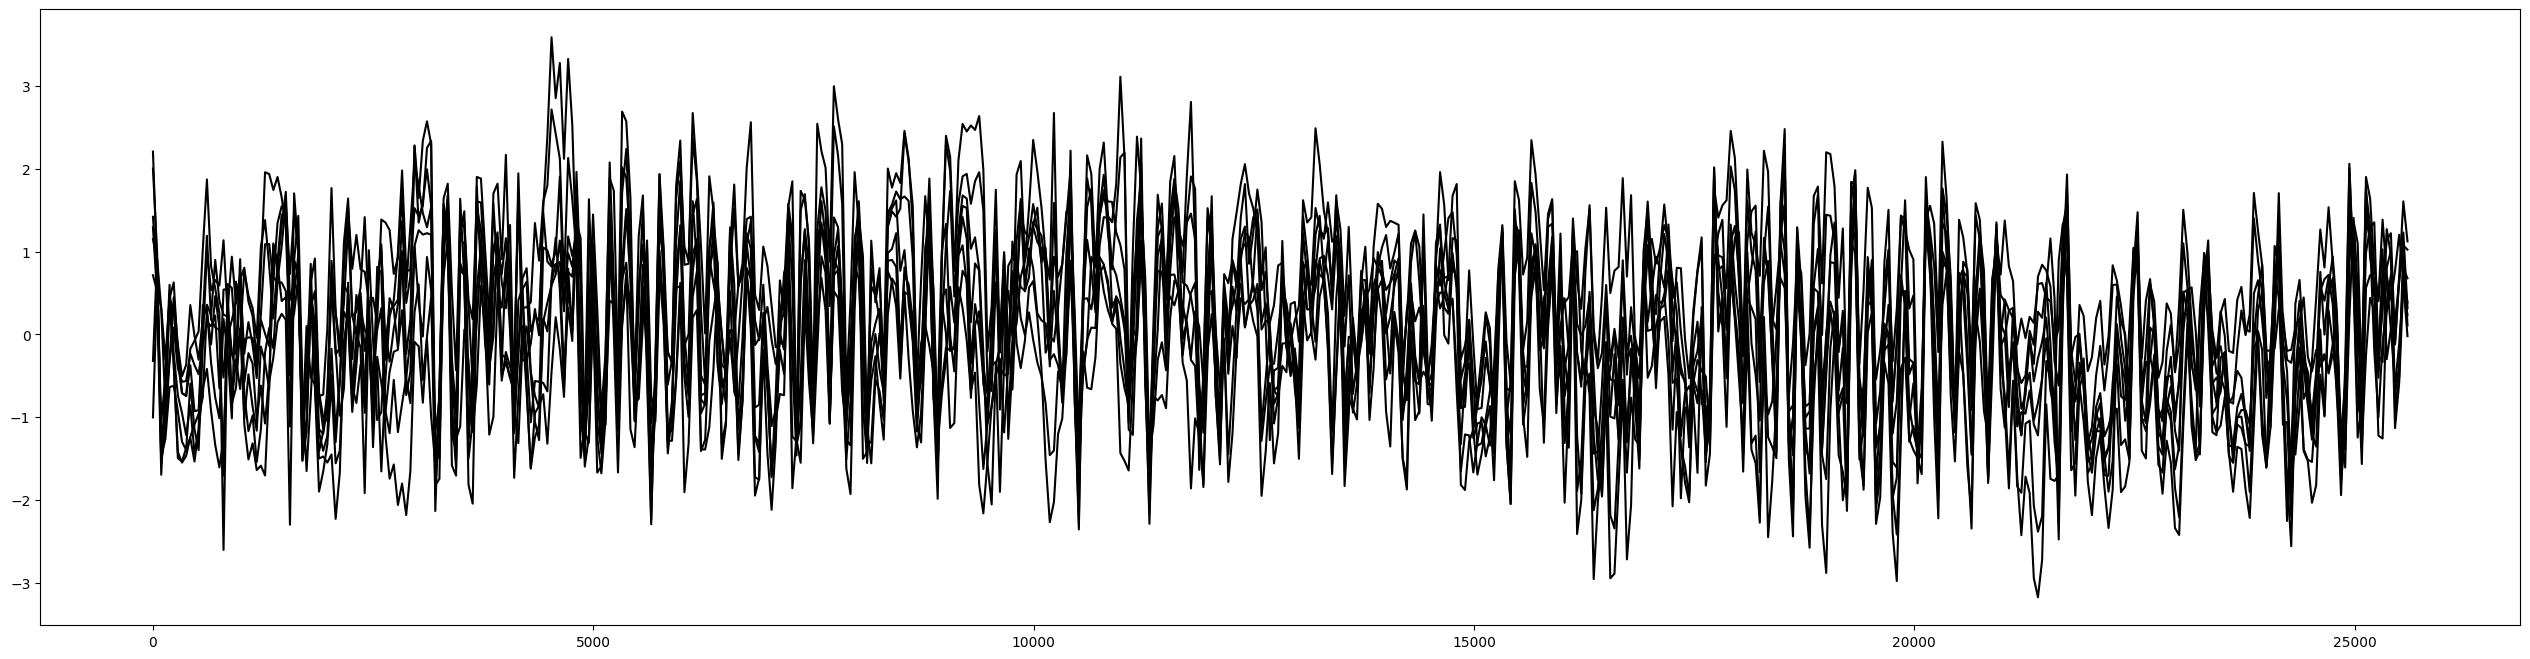

In [ ]:
#Load Dataset

# EEG_data = []
# path = "/content/gdrive/MyDrive/Colab Notebooks/FYP_coding/DataSet/"
# for subject in range(1,5):
#     eeg = mat73.loadmat(path+'s{:02d}.mat'.format(int(subject)))
#     EEG_data += eeg['train'] + eeg['test']

# Pre-processing for training EEG
eeg_data = []
eeg_data += EEG['train'] + EEG['test']


for n_calib in range(len(eeg_data)):
    # print(n_calib)
    cur_eeg = eeg_data[n_calib]

    data = np.asarray(cur_eeg['data'])
    srate = cur_eeg['srate']
    data = butter_bandpass_filter(data, 0.5, 10, srate, 4)
    markers = cur_eeg['markers_target']

    targetID = np.where(markers==1)[0]
    nontargetID = np.where(markers==2)[0]

    tmp_targetEEG = extractEpoch3D(data, targetID, srate, baseline, frame, True)
    tmp_nontargetEEG = extractEpoch3D(data, nontargetID, srate, baseline, frame, True)
    if n_calib == 0:
        targetEEG = tmp_targetEEG
        nontargetEEG = tmp_nontargetEEG
    else:
        targetEEG = np.dstack((targetEEG, tmp_targetEEG))
        nontargetEEG = np.dstack((nontargetEEG, tmp_nontargetEEG))


# Ensemble accross trials
num_of_target_signals = targetEEG.shape[2] // 128
num_of_nontarget_signals = nontargetEEG.shape[2] // 128
avg_target = np.zeros((targetEEG.shape[0], targetEEG.shape[1], num_of_target_signals))
avg_nontarget = np.zeros((nontargetEEG.shape[0], nontargetEEG.shape[1], num_of_nontarget_signals))

for i in range(num_of_target_signals):
  if i != num_of_target_signals-1:
    avg_target[:,:,i] = np.mean(targetEEG[:, :, i:i+128 ], axis=2)
  else:
    avg_target[:,:,i] = np.mean(targetEEG[:, :, i: ], axis=2)

for i in range(num_of_nontarget_signals):
  if i != num_of_nontarget_signals-1:
    avg_nontarget[:,:,i] = np.mean(nontargetEEG[:, :, i:i+128 ], axis=2)
  else:
    avg_nontarget[:,:,i] = np.mean(nontargetEEG[:, :, i: ], axis=2)


# Averaging in time axis
down_target = decimation_by_avg(avg_target, 24)
down_nontarget = decimation_by_avg(avg_nontarget, 24)



ch_target, frame_target, trial_target = down_target.shape
ch_nontarget, frame_nontarget, trial_nontarget = down_nontarget.shape

# ch x time x trial -> (ch* time) x trial -> trial x (ch*time)
feat_target = np.reshape(down_target, (ch_target*frame_target, trial_target)).transpose()
feat_nontarget = np.reshape(down_nontarget, (ch_nontarget*frame_nontarget, trial_nontarget)).transpose()

# # labels - (+1) for target and (-1) for nontarget
# y_target = np.ones((feat_target.shape[0],1))
# y_nontarget = -np.ones((feat_nontarget.shape[0],1))

# X_ = np.vstack((feat_target, feat_nontarget))
# y_ = np.vstack((y_target, y_nontarget))

# print(X_.shape, y_.shape)

# # shuffle target and nontarget indices
# np.random.seed(101)
# idx_train = np.arange(X_.shape[0])
# np.random.shuffle(idx_train)
# X_ = X_[idx_train, :]
# y_ = y_[idx_train, :]

# X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Standardize the features
scaler1 = StandardScaler()
feat_target = scaler1.fit_transform(feat_target)

scaler2 = StandardScaler()
feat_nontarget = scaler2.fit_transform(feat_nontarget)






# Plotting
t = np.linspace(0, 32*800 , feat_target.shape[1])
plt.figure(figsize=(32,8))

for trial in range(feat_target.shape[0]):
  plt.plot(t,feat_target[trial], color='yellow')
  plt.plot(t,feat_nontarget[trial], color='black')
plt.show()

plt.figure(figsize=(32,8))
for trial in range(feat_target.shape[0]):
  plt.plot(t,feat_target[trial], color='yellow')
plt.show()

plt.figure(figsize=(32,8))
for trial in range(feat_target.shape[0]):
  plt.plot(t,feat_nontarget[trial], color='black')
plt.show()




In [ ]:
print(down_target.shape)
print(feat_target.shape)

(32, 17, 8)
(8, 544)
